In [1]:
import os
import json
from pathlib import Path
import typing

import numpy as np
import torch
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTConfig

from muutils.logger import Logger, TimerContext
from muutils.json_serialize import json_serialize, dataclass_serializer_factory
from muutils.tensor_utils import ATensor
from muutils.statcounter import StatCounter
from muutils.misc import shorten_numerical_to_str

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import MazeTokenizer, SPECIAL_TOKENS
from maze_transformer.training.mazedataset import MazeDatasetConfig, MazeDataset
from maze_transformer.evaluation.plot_maze import plot_multi_paths, PathFormat
from maze_transformer.training.dataset import GPTDatasetConfig
from maze_transformer.training.config import TrainConfig
from maze_transformer.training.training import TRAIN_SAVE_FILES
from maze_transformer.evaluation.eval_model import generate_plot_predicted_path, MazePath, load_model_with_configs, LoadedModelConfigs, predict_maze_path



Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


loaded model with 28M parameters


Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consi

maze_tokens = ['<ADJLIST_START>', '(0,1)', '<-->', '(1,1)', ';', '(2,1)', '<-->', '(3,1)', ';', '(0,0)', '<-->', '(0,1)', ';', '(2,1)', '<-->', '(1,1)', ';', '(3,2)', '<-->', '(2,2)', ';', '(1,2)', '<-->', '(2,2)', ';', '(2,3)', '<-->', '(1,3)', ';', '(0,3)', '<-->', '(0,2)', ';', '(1,2)', '<-->', '(1,3)', ';', '(2,0)', '<-->', '(3,0)', ';', '(3,3)', '<-->', '(2,3)', ';', '(3,1)', '<-->', '(3,2)', ';', '(1,3)', '<-->', '(0,3)', ';', '(3,1)', '<-->', '(3,0)', ';', '(1,0)', '<-->', '(0,0)', ';', '<ADJLIST_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<START_PATH>']
path_true_tokens = ['(0,0)', '(0,1)', '(1,1)', '(2,1)', '(3,1)', '(3,2)', '(2,2)', '(1,2)', '(1,3)', '(2,3)', '(3,3)', '<END_PATH>']
predicted_and_context_tokens = ['<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<ADJLIST_START>', '(0,1)', '<-->', '(1

Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 90, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


maze_tokens = ['<ADJLIST_START>', '(3,3)', '<-->', '(3,2)', ';', '(0,3)', '<-->', '(0,2)', ';', '(1,3)', '<-->', '(0,3)', ';', '(2,1)', '<-->', '(2,0)', ';', '(2,0)', '<-->', '(3,0)', ';', '(1,3)', '<-->', '(2,3)', ';', '(0,0)', '<-->', '(0,1)', ';', '(2,2)', '<-->', '(3,2)', ';', '(2,3)', '<-->', '(3,3)', ';', '(1,2)', '<-->', '(1,1)', ';', '(1,1)', '<-->', '(2,1)', ';', '(3,1)', '<-->', '(3,0)', ';', '(2,2)', '<-->', '(1,2)', ';', '(1,0)', '<-->', '(2,0)', ';', '(1,0)', '<-->', '(0,0)', ';', '<ADJLIST_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<START_PATH>']
path_true_tokens = ['(0,0)', '(1,0)', '(2,0)', '(2,1)', '(1,1)', '(1,2)', '(2,2)', '(3,2)', '(3,3)', '<END_PATH>']
predicted_and_context_tokens = ['<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<ADJLIST_START>', '(3,3)', '<-->', '(3,2)', ';', '(0,3)'

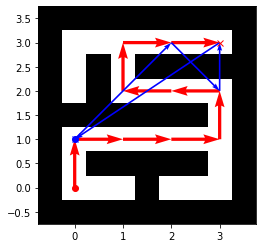

(4, 4)


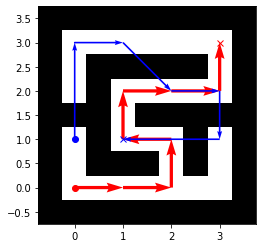

In [2]:
# setup consts
model_path: str = "data/g4-n4K/g4-n4K_tiny-v1_2022-09-10-02-02-12/checkpoints/model.iter_3120.pt"
n_mazes: int = 2
n_tokens_pred: int = 8
filename: str = "data/g4-n1K-test/maze_tokens.jsonl"
mazes_tokens: list[list[str]] = list()

# load model and configs
loaded_model_and_configs: LoadedModelConfigs = load_model_with_configs(model_path, MazeDatasetConfig)
data_cfg: MazeDatasetConfig; train_cfg: TrainConfig
model_cfg: OpenAIGPTConfig; model: OpenAIGPTLMHeadModel
data_cfg, train_cfg, model_cfg, model = loaded_model_and_configs

# load maze test data
with open(filename, "r") as f:
	for line in f:
		mazes_tokens.append(line.split())

mazes_tokens = mazes_tokens[:n_mazes]

mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = [
	predict_maze_path(
		tokens = tokens,
		data_cfg = data_cfg,
		model = model,
		n_tokens_pred = n_tokens_pred,
	)
	for tokens in mazes_tokens
]
	

# plot
for maze, path, path_pred in mazes_solved:
	plot_multi_paths(
		maze = maze,
		paths = [
			PathFormat(path, "true", color = "red", quiver_kwargs = {'width': 0.015}),
			PathFormat(path_pred, "predicted", color = "blue", quiver_kwargs = {}),
		],
	)

In [3]:


# generate_plot_predicted_path("data/g4-n4K/g4-n4K_tiny-v1_2022-09-10-02-02-12/checkpoints/model.iter_3120.pt")
